In [2]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras import layers

2024-07-03 20:39:53.002521: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-03 20:39:53.034408: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-03 20:39:53.512926: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#Coletando dados

df = pd.read_excel('/home/andre/Downloads/RJ_Reconstrucao_Moluscos_2024_06_25.xlsx')
df_TOTAL_MOLLUSCS_e_lulas = pd.DataFrame(df[['Ano','Lula_art','Lula_ind','Lula_art_ind','TOTAL_MOLLUSCS']])

df_TOTAL_MOLLUSCS_e_lulas['Lula_art_ind'] = df_TOTAL_MOLLUSCS_e_lulas.loc[:,('Lula_art','Lula_ind','Lula_art_ind')].sum(axis=1)
dados = df_TOTAL_MOLLUSCS_e_lulas[['Ano','Lula_art_ind','TOTAL_MOLLUSCS']].replace(0,np.nan).dropna().reset_index(drop=True)

anos_com_dados = dados["Ano"].values
anos_para_prever = np.array([1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1965,1969,1970,1971,1972,1973,1974,1975,1976,1977])
todos_anos = np.concatenate((anos_para_prever, anos_com_dados))
todos_anos.sort()

#Fazendo as proporções
for i in range(len(dados['Ano'])):
  dados.loc[i,'Prop_Lula'] = dados.loc[i,'Lula_art_ind'] / dados.loc[i,'TOTAL_MOLLUSCS']



prop = dados['Prop_Lula'].values
dados.head()

,Ano,Lula_art_ind,TOTAL_MOLLUSCS,Prop_Lula
0,1962,22.0,38.0,0.578947
1,1963,57.0,141.0,0.404255
2,1964,71.0,708.0,0.100282
3,1966,21.0,75.0,0.280000
4,1967,70.0,145.0,0.482759


In [4]:
#Normalização dos dados

ano_mean = np.mean(anos_com_dados)
ano_std = np.std(anos_com_dados)
anos_para_prever_norm = (anos_para_prever - ano_mean)/ano_std
anos_com_dados_norm = (anos_com_dados - ano_mean)/ano_std

prop_mean = np.mean(prop)
prop_std = np.std(prop)
prop_norm = (prop - prop_mean)/prop_std

In [5]:
#Fit do modelo e salvando seus pesos
model = keras.Sequential([layers.Dense(96,activation='leaky_relu',input_shape=(1,)),
                             layers.Dense(32,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(96,activation='leaky_relu'),
                             layers.Dense(112,activation='leaky_relu'),
                             layers.Dense(1,activation='linear')])

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')


history = model.fit(anos_com_dados_norm,prop_norm, epochs=500, verbose=1)
model.save_weights('/home/andre/Área de Trabalho/Projeto da pesca/Rio de Janeiro/Moluscos/Lulas/pesos prop lulas/.weights.h5', overwrite=True)

Epoch 1/500


/home/andre/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step - loss: 1.0106
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9940
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9809
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9681
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9539
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9383
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.9210
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9018
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8807
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.8583
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8356
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8135
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7932
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7765
Epoch 15/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7622
Epoch 16/500
1/1 ━━━━━━━━━━━━━

In [6]:
model.load_weights('/home/andre/Área de Trabalho/Projeto da pesca/Rio de Janeiro/Moluscos/Lulas/pesos prop lulas/.weights.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Previsões dos dados ausentes: [[1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.9057188 ]
 [0.74635416]
 [0.08472532]
 [0.7804648 ]
 [0.82573235]
 [0.8643664 ]
 [0.89789   ]
 [0.92431945]
 [0.9412446 ]
 [0.9507262 ]
 [0.9590148 ]
 [0.9586657 ]]


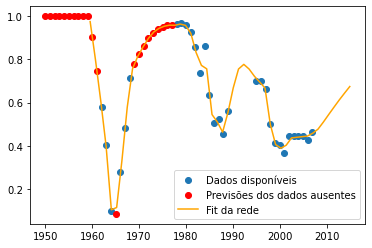

In [8]:
#Previsões
prev_disponiveis = model.predict(anos_com_dados_norm)*prop_std + prop_mean
prev_ausentes = model.predict(anos_para_prever_norm)*prop_std + prop_mean

#Colocando valores negativos para 0
for i in range(len(prev_ausentes)):
    if prev_ausentes[i]<0:
        prev_ausentes[i]=0
    if prev_ausentes[i]>=1:
        prev_ausentes[i]=1

#Plot dos dados e previsões
f1=plt.figure(1).add_subplot()
f1.scatter(anos_com_dados,prop,label='Dados disponíveis')
f1.scatter(anos_para_prever,prev_ausentes, color='red', label='Previsões dos dados ausentes')

#Plot do fit da rede
p = np.linspace(-2,2,50)
y = model.predict(p)*prop_std + prop_mean
f1.plot(p*ano_std + ano_mean,y,color='orange',label='Fit da rede')

#Print das previsões
print('Previsões dos dados ausentes:', prev_ausentes)


plt.legend()
plt.show()

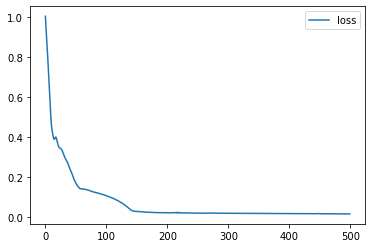

In [36]:
loss = history.history['loss']
plt.plot(loss,label='loss')
plt.legend()
plt.show()